In [19]:
!pip install kagglehub albumentations lxml --quiet


In [20]:
import kagglehub
gopalbhattrai_pascal_voc_2012_dataset_path = kagglehub.dataset_download('gopalbhattrai/pascal-voc-2012-dataset')

print('Data source import complete.')


Data source import complete.


In [21]:
import os
import glob
import torch
import torchvision
import torchvision.transforms as T
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
import numpy as np
import xml.etree.ElementTree as ET
import cv2
import albumentations as A
import matplotlib.pyplot as plt
import kagglehub
from kagglehub import KaggleDatasetAdapter
import random
import traceback

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)


Using: cuda


In [22]:

import kagglehub


dataset_path = kagglehub.dataset_download("gopalbhattrai/pascal-voc-2012-dataset")

print("Dataset downloaded to:", dataset_path)


✅ Dataset downloaded to: /kaggle/input/pascal-voc-2012-dataset


In [23]:

import os


IMG_DIR = os.path.join(dataset_path, "VOC2012_train_val", "VOC2012_train_val", "JPEGImages")
ANN_DIR = os.path.join(dataset_path, "VOC2012_train_val", "VOC2012_train_val", "Annotations")


IMG_DIR_TEST = os.path.join(dataset_path, "VOC2012_test", "VOC2012_test", "JPEGImages")
ANN_DIR_TEST = os.path.join(dataset_path, "VOC2012_test", "VOC2012_test", "Annotations")

print("Train Images:", IMG_DIR)
print("Train Annotations:", ANN_DIR)
print("Test Images:", IMG_DIR_TEST)
print("Test Annotations:", ANN_DIR_TEST)


📂 Train Images: /kaggle/input/pascal-voc-2012-dataset/VOC2012_train_val/VOC2012_train_val/JPEGImages
📂 Train Annotations: /kaggle/input/pascal-voc-2012-dataset/VOC2012_train_val/VOC2012_train_val/Annotations
📂 Test Images: /kaggle/input/pascal-voc-2012-dataset/VOC2012_test/VOC2012_test/JPEGImages
📂 Test Annotations: /kaggle/input/pascal-voc-2012-dataset/VOC2012_test/VOC2012_test/Annotations


In [24]:
import xml.etree.ElementTree as ET
base_classes = ['aeroplane','bicycle','bird','boat','bottle',
                'bus','car','cat','chair','cow',
                'diningtable','dog','horse','motorbike','person']  
novel_classes = ['pottedplant','sheep','sofa','train','tvmonitor'] 
class_to_idx = {c:i+1 for i,c in enumerate(base_classes+novel_classes)}  



VOC_CLASSES = [
    "aeroplane", "bicycle", "bird", "boat", "bottle",
    "bus", "car", "cat", "chair", "cow",
    "diningtable", "dog", "horse", "motorbike", "person",
    "pottedplant", "sheep", "sofa", "train", "tvmonitor"
]
CLASS2IDX = {cls: i+1 for i, cls in enumerate(VOC_CLASSES)}  

def parse_voc_xml(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()

    boxes = []
    labels = []

    for obj in root.findall("object"):
        cls = obj.find("name").text.lower().strip()
        if cls not in CLASS2IDX:  
            continue
        xmlbox = obj.find("bndbox")
        xmin = int(xmlbox.find("xmin").text)
        ymin = int(xmlbox.find("ymin").text)
        xmax = int(xmlbox.find("xmax").text)
        ymax = int(xmlbox.find("ymax").text)

        boxes.append([xmin, ymin, xmax, ymax])
        labels.append(CLASS2IDX[cls])

    return {"boxes": boxes, "labels": labels}


In [25]:
class PascalVOCDataset(Dataset):
    def __init__(self, img_dir, ann_dir, transforms=None):
        self.img_dir = img_dir
        self.ann_dir = ann_dir
        self.transforms = transforms
        self.ids = [os.path.splitext(f)[0] for f in os.listdir(ann_dir) if f.endswith(".xml")]

    def __len__(self): return len(self.ids)

    def __getitem__(self, idx):
        img_id = self.ids[idx]
        img_path = os.path.join(self.img_dir, f"{img_id}.jpg")
        ann_path = os.path.join(self.ann_dir, f"{img_id}.xml")

        
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        
        ann = parse_voc_xml(ann_path)
        boxes = ann["boxes"]
        labels = ann["labels"]

       
        if self.transforms:
            aug = self.transforms(
                image=img,
                bboxes=boxes,     
                labels=labels      
            )
            img = aug["image"]
            boxes = aug["bboxes"]
            labels = aug["labels"]

        
        if isinstance(img, np.ndarray):
            img = torch.from_numpy(img).permute(2, 0, 1).float() / 255.0

        target = {
            "boxes": torch.tensor(boxes, dtype=torch.float32),
            "labels": torch.tensor(labels, dtype=torch.int64)  
        }

        return img, target



transform_train = A.Compose([A.Resize(400,400), A.HorizontalFlip(p=0.5)],
                            bbox_params=A.BboxParams(format="pascal_voc", label_fields=["labels"]))
transform_val = A.Compose([A.Resize(400,400)],
                         bbox_params=A.BboxParams(format="pascal_voc", label_fields=["labels"]))

full_ds = PascalVOCDataset(IMG_DIR, ANN_DIR, transforms=transform_train)


random.seed(42) 
subset_ids = random.sample(range(len(full_ds)), min(500, len(full_ds)))  
train_ds = Subset(full_ds, subset_ids)

val_ds = PascalVOCDataset(IMG_DIR, ANN_DIR, transforms=transform_val)

print("Train samples (tiny):", len(train_ds))
print("Dataset check - first sample:")
try:
    img, target = train_ds[0]
    print(f"Image shape: {img.shape}")
    print(f"Boxes: {target['boxes'].shape}")
    print(f"Labels: {target['labels'].shape}")
    print(f"Labels values: {target['labels']}")
except Exception as e:
    print(f"Error loading first sample: {e}")
    print("Checking dataset paths...")
    print(f"IMG_DIR exists: {os.path.exists(IMG_DIR)}")
    print(f"ANN_DIR exists: {os.path.exists(ANN_DIR)}")
    if os.path.exists(ANN_DIR):
        print(f"Number of annotations: {len(os.listdir(ANN_DIR))}")
    exit(1)

Train samples (tiny): 500
Dataset check - first sample:
Image shape: torch.Size([3, 400, 400])
Boxes: torch.Size([1, 4])
Labels: torch.Size([1])
Labels values: tensor([15])


In [26]:
class CosineClassifier(nn.Module):
    def __init__(self, in_dim, num_classes, scale=20.0):
        super().__init__()
        self.scale = scale
        self.weight = nn.Parameter(torch.Tensor(num_classes, in_dim))
        nn.init.xavier_uniform_(self.weight)
    def forward(self, x):
        x_norm = F.normalize(x, p=2, dim=1)
        w_norm = F.normalize(self.weight, p=2, dim=1)
        return self.scale * x_norm @ w_norm.t()

def get_model(num_classes):
    backbone = torchvision.models.resnet18(weights="IMAGENET1K_V1")
    backbone = nn.Sequential(*list(backbone.children())[:-2])
    backbone.out_channels = 512
    anchor_gen = torchvision.models.detection.rpn.AnchorGenerator(
        sizes=((32,64,128,256,512),), aspect_ratios=((0.5,1.0,2.0),))
    roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=["0"], output_size=7, sampling_ratio=2)
    model = torchvision.models.detection.FasterRCNN(
        backbone, num_classes=num_classes,
        rpn_anchor_generator=anchor_gen, box_roi_pool=roi_pooler)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor.cls_score = CosineClassifier(in_features, num_classes)
    return model

def collate_fn(batch): return tuple(zip(*batch))


# **Stage I: Training a base Faster R-CNN model on base classes.**

In [27]:
num_classes = len(base_classes+novel_classes)+1
model = get_model(num_classes).to(device)
train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, collate_fn=collate_fn)  

optimizer = torch.optim.SGD([p for p in model.parameters() if p.requires_grad],
                            lr=0.002, momentum=0.9, weight_decay=0.0005)  


scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

print("Stage 1 training...")
for epoch in range(15):  
    model.train()
    epoch_loss = 0
    num_batches = 0
    for batch_idx, (imgs, targets) in enumerate(train_loader):
        imgs = [img.to(device) for img in imgs]
        targets = [{k:v.to(device) for k,v in t.items()} for t in targets]
        
        
        valid_targets = []
        valid_imgs = []
        for img, target in zip(imgs, targets):
            if len(target["boxes"]) > 0:  
                valid_targets.append(target)
                valid_imgs.append(img)
        
        if len(valid_targets) == 0:
            continue
            
        loss_dict = model(valid_imgs, valid_targets)
        loss = sum(loss for loss in loss_dict.values())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        num_batches += 1
        
        if batch_idx % 10 == 0:
            print(f"Epoch {epoch+1}, Batch {batch_idx}, Loss: {loss.item():.4f}")
    
    avg_loss = epoch_loss / max(num_batches, 1)
    print(f"Epoch {epoch+1} completed - Average Loss: {avg_loss:.4f}")
    scheduler.step()  
print("Stage 1 completed")


Stage 1 training...
Epoch 1, Batch 0, Loss: 4.6082
Epoch 1, Batch 10, Loss: 0.8778
Epoch 1, Batch 20, Loss: 0.6747
Epoch 1, Batch 30, Loss: 0.5822
Epoch 1, Batch 40, Loss: 0.7302
Epoch 1, Batch 50, Loss: 0.4487
Epoch 1, Batch 60, Loss: 0.6714
Epoch 1, Batch 70, Loss: 0.3846
Epoch 1, Batch 80, Loss: 0.2791
Epoch 1, Batch 90, Loss: 0.5387
Epoch 1, Batch 100, Loss: 0.4336
Epoch 1, Batch 110, Loss: 0.4484
Epoch 1, Batch 120, Loss: 0.7385
Epoch 1 completed - Average Loss: 0.6576
Epoch 2, Batch 0, Loss: 0.6684
Epoch 2, Batch 10, Loss: 0.6911
Epoch 2, Batch 20, Loss: 0.4855
Epoch 2, Batch 30, Loss: 0.5563
Epoch 2, Batch 40, Loss: 0.4821
Epoch 2, Batch 50, Loss: 0.4765
Epoch 2, Batch 60, Loss: 0.6554
Epoch 2, Batch 70, Loss: 0.5412
Epoch 2, Batch 80, Loss: 0.6236
Epoch 2, Batch 90, Loss: 0.7002
Epoch 2, Batch 100, Loss: 0.5487
Epoch 2, Batch 110, Loss: 0.8745
Epoch 2, Batch 120, Loss: 0.5738
Epoch 2 completed - Average Loss: 0.5674
Epoch 3, Batch 0, Loss: 0.3944
Epoch 3, Batch 10, Loss: 0.3532

# **Stage II: Fine-tuning only the detection head using few-shot novel samples.**

In [34]:
K = 3
fewshot_idx, class_counts = [], {c:0 for c in class_to_idx.values()}

print("Collecting few-shot samples...")
for i in subset_ids:
    try:
        _, t = full_ds[i]
        for l in t["labels"].tolist():
            if l in class_counts and class_counts[l]<K:
                fewshot_idx.append(i)
                class_counts[l]+=1
                break  
        if len(fewshot_idx) >= K * len(class_to_idx):  
            break
    except Exception as e:
        print(f"Skip sample {i}: {e}")
        continue

print(f"Few-shot samples collected: {len(fewshot_idx)}")
if len(fewshot_idx) == 0:
    print("Skip Stage 2")
else:
    fewshot_loader = DataLoader(Subset(full_ds, fewshot_idx),
                                batch_size=4, shuffle=True, collate_fn=collate_fn)  

    
    for p in model.backbone.parameters(): p.requires_grad=False
    for p in model.rpn.parameters(): p.requires_grad=False
    optimizer = torch.optim.SGD([p for p in model.parameters() if p.requires_grad], lr=0.00025, momentum=0.9)

    print("Stage 2 few-shot fine-tune...")
    for epoch in range(5):  
        model.train()
        epoch_loss = 0
        num_batches = 0
        for batch_idx, (imgs, targets) in enumerate(fewshot_loader):
            imgs = [img.to(device) for img in imgs]
            targets = [{k:v.to(device) for k,v in t.items()} for t in targets]
            
            
            valid_targets = []
            valid_imgs = []
            for img, target in zip(imgs, targets):
                if len(target["boxes"]) > 0:  
                    valid_targets.append(target)
                    valid_imgs.append(img)
            
            if len(valid_targets) == 0:
                continue
                
            loss_dict = model(valid_imgs, valid_targets)
            loss = sum(loss for loss in loss_dict.values())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            num_batches += 1
            
            if batch_idx % 5 == 0:
                print(f"Few-shot Epoch {epoch+1}, Batch {batch_idx}, Loss: {loss.item():.4f}")
        
        avg_loss = epoch_loss / max(num_batches, 1)
        print(f"Few-shot Epoch {epoch+1} completed - Average Loss: {avg_loss:.4f}")
    print("Stage 2 completed")


Few-shot samples collected: 60
Stage 2 few-shot fine-tune...
Few-shot Epoch 1, Batch 0, Loss: 0.8369
Few-shot Epoch 1, Batch 5, Loss: 0.5156
Few-shot Epoch 1, Batch 10, Loss: 0.3993
Few-shot Epoch 1 completed - Average Loss: 0.5137
Few-shot Epoch 2, Batch 0, Loss: 0.4987
Few-shot Epoch 2, Batch 5, Loss: 0.6710
Few-shot Epoch 2, Batch 10, Loss: 0.7836
Few-shot Epoch 2 completed - Average Loss: 0.5053
Few-shot Epoch 3, Batch 0, Loss: 0.3491
Few-shot Epoch 3, Batch 5, Loss: 0.2731
Few-shot Epoch 3, Batch 10, Loss: 0.2941
Few-shot Epoch 3 completed - Average Loss: 0.5027
Few-shot Epoch 4, Batch 0, Loss: 0.3940
Few-shot Epoch 4, Batch 5, Loss: 0.3378
Few-shot Epoch 4, Batch 10, Loss: 0.4360
Few-shot Epoch 4 completed - Average Loss: 0.5032
Few-shot Epoch 5, Batch 0, Loss: 0.5322
Few-shot Epoch 5, Batch 5, Loss: 0.6875
Few-shot Epoch 5, Batch 10, Loss: 0.3243
Few-shot Epoch 5 completed - Average Loss: 0.4994
Stage 2 completed


Testing with sample 50
Ground truth labels: [2]
Ground truth boxes: torch.Size([1, 4])
Predictions - Scores: tensor([0.1016, 0.0979, 0.0902, 0.0833, 0.0810, 0.0787, 0.0760, 0.0736, 0.0669,
        0.0655], device='cuda:0')
Predictions - Labels: tensor([15, 10,  1,  2, 15, 14, 14,  6, 19, 14], device='cuda:0')
Number of detections: 23
Displaying 1 detections above threshold 0.1


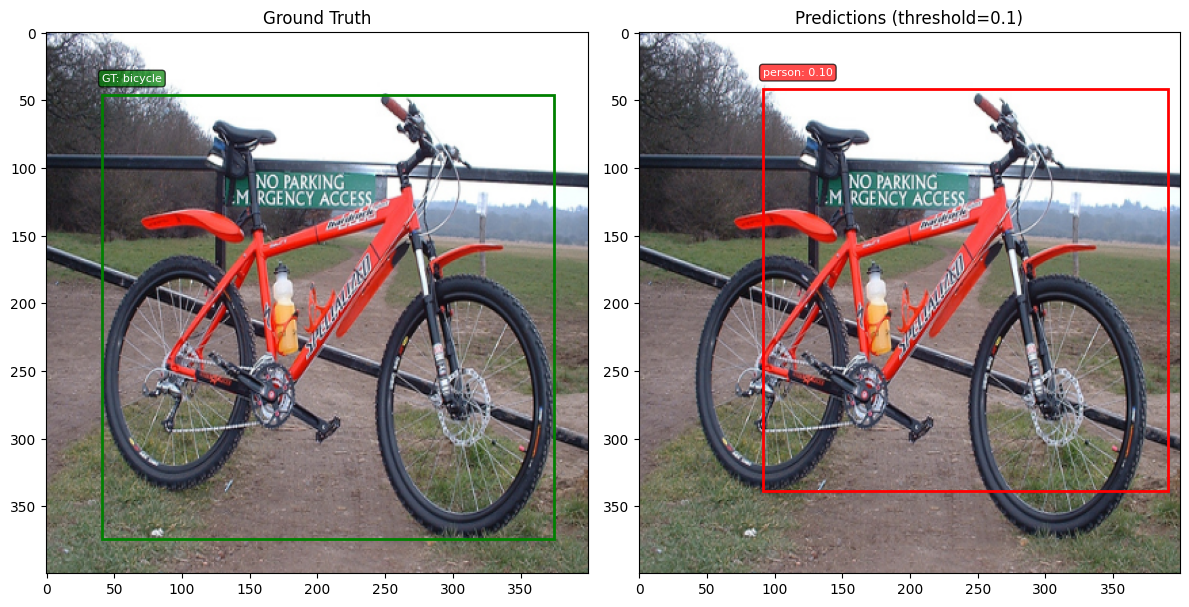

Done
Displaying 1 detections above threshold 0.1


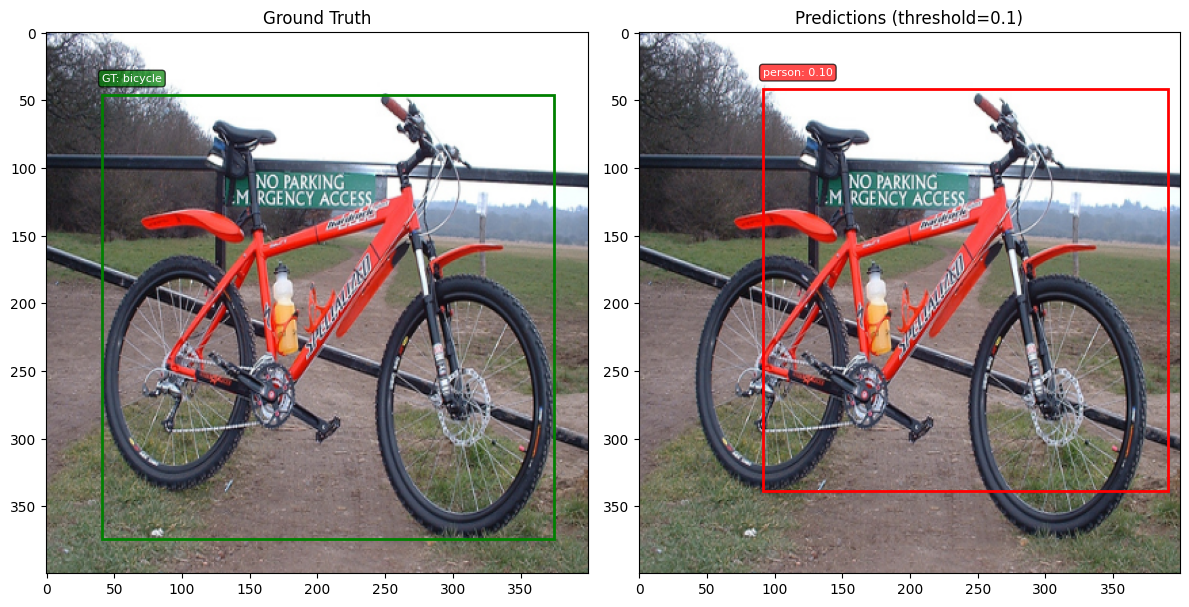

In [41]:
model.eval()
try:
    
    sample_idx = min(50, len(val_ds)-1)
    img, target = val_ds[sample_idx]
    print(f"Testing with sample {sample_idx}")
    print(f"Ground truth labels: {target['labels'].numpy()}")
    print(f"Ground truth boxes: {target['boxes'].shape}")
    
    with torch.no_grad():
        pred = model([img.to(device)])[0]
    
    print(f"Predictions - Scores: {pred['scores'][:10]}") 
    print(f"Predictions - Labels: {pred['labels'][:10]}") 
    print(f"Number of detections: {len(pred['boxes'])}")

    def show_pred(img, pred, target, score_threshold=0.1,save_path=None): 
        
        if isinstance(img, torch.Tensor):
            img_np = img.permute(1,2,0).cpu().numpy()
            
            img_np = np.clip(img_np, 0, 1)
        else:
            img_np = img
            
        plt.figure(figsize=(12,8))
        plt.subplot(1,2,1)
        plt.imshow(img_np)
        plt.title("Ground Truth")
        
        
        for i, (box, label) in enumerate(zip(target['boxes'], target['labels'])):
            x1, y1, x2, y2 = box.cpu().numpy()
            plt.gca().add_patch(plt.Rectangle((x1,y1), x2-x1, y2-y1,
                                              fill=False, edgecolor='green', linewidth=2))
            plt.text(x1, y1-10, f'GT: {VOC_CLASSES[label.item()-1]}',
                    bbox=dict(boxstyle="round,pad=0.3", facecolor='green', alpha=0.7),
                    fontsize=8, color='white')
        
        plt.subplot(1,2,2)
        plt.imshow(img_np)
        plt.title(f"Predictions (threshold={score_threshold})")
        
        
        num_detections = 0
        for box, score, label in zip(pred['boxes'], pred['scores'], pred['labels']):
            if score > score_threshold:
                num_detections += 1
                x1, y1, x2, y2 = box.cpu().numpy()
                plt.gca().add_patch(plt.Rectangle((x1,y1), x2-x1, y2-y1,
                                                  fill=False, edgecolor='red', linewidth=2))
                
                class_name = VOC_CLASSES[label.item()-1] if label.item() <= len(VOC_CLASSES) else f"Class{label.item()}"
                plt.text(x1, y1-10, f'{class_name}: {score:.2f}',
                        bbox=dict(boxstyle="round,pad=0.3", facecolor='red', alpha=0.7),
                        fontsize=8, color='white')
        
        print(f"Displaying {num_detections} detections above threshold {score_threshold}")
        plt.tight_layout()
        plt.show()

    show_pred(img, pred, target)
    print("Done")
    
except Exception as e:
    print(f"inference error: {e}")
    import traceback
    traceback.print_exc()

    # ✅ Lưu ảnh nếu có đường dẫn
    if save_path is not None:
        plt.savefig(save_path, dpi=150)
        print(f"Saved figure to {save_path}")
    
    plt.show()
show_pred(img, pred, target, save_path="voc_prediction.png")
